"""
本文件功能说明：
- Phase 2: Feature Engineering (特征工程)
- 从9个原始特征扩展为59个工程特征
- 创建文本特征（12个）：标题长度、特殊符号、关键词等
- 创建时间特征（17个）：发布年份、月份、星期、时段等
- 创建参与特征（19个）：参与率、加权参与度、互动比例等
- 创建频道特征（15个）：频道平均值、总计、排名等
- 创建复合特征（8个）：视频与频道对比指标
- 输出标准化和原始特征数据集到engineered_features_raw.csv和engineered_features_scaled.csv
"""

## Part 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import re
import warnings
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
import glob

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("All libraries imported successfully!")

All libraries imported successfully!


## Part 2: Load and Explore Raw Data

In [2]:
# Load data from all years
output_dir = 'datasets_by_year'
csv_files = sorted(glob.glob(os.path.join(output_dir, 'youtube_videos_*.csv')))

# Combine all yearly data
dfs = []
for csv_file in csv_files:
    df_year = pd.read_csv(csv_file)
    dfs.append(df_year)
    
df = pd.concat(dfs, ignore_index=True)

print(f"Data loaded successfully:")
print(f"   - Total rows: {len(df):,}")
print(f"   - Original columns: {len(df.columns)}")
print(f"   - Column names: {list(df.columns)}")
print(f"\n Data preview:")
print(df.head())
print(f"\n Basic statistics:")
print(df.describe())

Data loaded successfully:
   - Total rows: 155,669
   - Original columns: 10
   - Column names: ['video_id', 'title', 'channel_name', 'channel_id', 'view_count', 'like_count', 'comment_count', 'published_date', 'thumbnail', 'year']

 Data preview:
      video_id                           title     channel_name  \
0  MDbZdXCdEVE        Meikyo - Shotokan Karate  shotokankataman   
1  R1KqSlnu4JE     Kanku Sho - Shotokan Karate  shotokankataman   
2  efxiTKgiXS8     Nijushiho - Shotokan Karate  shotokankataman   
3  -bmF_F2bDoc  Tekki Sandan - Shotokan Karate  shotokankataman   
4  RiG93fNAmz0         Ji'in - Shotokan Karate  shotokankataman   

                 channel_id  view_count  like_count  comment_count  \
0  UC2LfRT9-HMeq5d4CiozF9BQ      454506        2437            101   
1  UC2LfRT9-HMeq5d4CiozF9BQ     1145296        6194            197   
2  UC2LfRT9-HMeq5d4CiozF9BQ      656443        3368             98   
3  UC2LfRT9-HMeq5d4CiozF9BQ      918996        4232            151   

In [3]:
# Data type conversion
df['published_date'] = pd.to_datetime(df['published_date'])
df['view_count'] = pd.to_numeric(df['view_count'], errors='coerce')
df['like_count'] = pd.to_numeric(df['like_count'], errors='coerce')
df['comment_count'] = pd.to_numeric(df['comment_count'], errors='coerce')

# Check data quality
print("Data quality check:")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nData types:\n{df.dtypes}")

Data quality check:
Missing values:
video_id          0
title             0
channel_name      0
channel_id        0
view_count        0
like_count        0
comment_count     0
published_date    0
thumbnail         0
year              0
dtype: int64

Data types:
video_id                       object
title                          object
channel_name                   object
channel_id                     object
view_count                      int64
like_count                      int64
comment_count                   int64
published_date    datetime64[ns, UTC]
thumbnail                      object
year                            int64
dtype: object


## Part 3: Create Text Feature Engineering (10 features)

Extract text features from titles, reflecting content complexity and attractiveness.

In [4]:
# Create text features
df_features = df.copy()

# 1. Title length
df_features['title_length'] = df_features['title'].str.len()

# 2. Title word count
df_features['title_word_count'] = df_features['title'].str.split().str.len()

# 3. Average word length
df_features['title_avg_word_length'] = df_features.apply(
    lambda row: np.mean([len(word) for word in str(row['title']).split()]) if len(str(row['title']).split()) > 0 else 0,
    axis=1
)

# 4. Contains question mark
df_features['title_has_question'] = df_features['title'].str.contains(r'\?', regex=True).astype(int)

# 5. Contains exclamation mark
df_features['title_has_exclamation'] = df_features['title'].str.contains(r'!', regex=True).astype(int)

# 6. Uppercase letter ratio
df_features['title_uppercase_ratio'] = df_features['title'].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
)

# 7. Digit count
df_features['title_digit_count'] = df_features['title'].str.count(r'\d')

# 8. Special character count
df_features['title_special_char_count'] = df_features['title'].apply(
    lambda x: sum(1 for c in str(x) if not c.isalnum() and c not in ' ')
)

# 9. Contains numbers
df_features['title_has_numbers'] = df_features['title'].str.contains(r'\d', regex=True).astype(int)

# 10. Contains brackets
df_features['title_has_brackets'] = df_features['title'].str.contains(r'[\(\[\{]', regex=True).astype(int)

print("Text features created (10):")
text_features = [col for col in df_features.columns if col.startswith('title_') and col != 'title']
print(f"   {text_features}")
print(f"\n Text features preview:")
print(df_features[text_features].head())

Text features created (10):
   ['title_length', 'title_word_count', 'title_avg_word_length', 'title_has_question', 'title_has_exclamation', 'title_uppercase_ratio', 'title_digit_count', 'title_special_char_count', 'title_has_numbers', 'title_has_brackets']

 Text features preview:
   title_length  title_word_count  title_avg_word_length  title_has_question  \
0            24                 4                   5.25                   0   
1            27                 5                   4.60                   0   
2            27                 4                   6.00                   0   
3            30                 5                   5.20                   0   
4            23                 4                   5.00                   0   

   title_has_exclamation  title_uppercase_ratio  title_digit_count  \
0                      0               0.125000                  0   
1                      0               0.148148                  0   
2                      0   

## Part 4: Create Temporal Feature Engineering (13 features)

Extract time-related features from publish date to help discover temporal patterns.

In [5]:
# Create temporal features
# Reference date (use the latest date in the data)
ref_date = df_features['published_date'].max()

# 1. Publish year
df_features['publish_year'] = df_features['published_date'].dt.year

# 2. Publish month
df_features['publish_month'] = df_features['published_date'].dt.month

# 3. Publish day
df_features['publish_day'] = df_features['published_date'].dt.day

# 4. Publish hour
df_features['publish_hour'] = df_features['published_date'].dt.hour

# 5. Day of week (0=Monday, 6=Sunday)
df_features['publish_dayofweek'] = df_features['published_date'].dt.dayofweek

# 6. Is weekend (Saturday=5, Sunday=6)
df_features['is_weekend'] = (df_features['publish_dayofweek'] >= 5).astype(int)

# 7. Is working hours
df_features['is_working_hours'] = (
    (df_features['publish_hour'] >= 9) & 
    (df_features['publish_hour'] <= 17) & 
    (df_features['publish_dayofweek'] < 5)
).astype(int)

# 8. Is prime time (19:00-22:00)
df_features['is_prime_time'] = (
    (df_features['publish_hour'] >= 19) & 
    (df_features['publish_hour'] <= 22)
).astype(int)

# 9. Days since publish
df_features['days_since_publish'] = (ref_date - df_features['published_date']).dt.days

# 10. Months since publish
df_features['months_since_publish'] = df_features['days_since_publish'] // 30

# 11. Years since publish
df_features['years_since_publish'] = df_features['days_since_publish'] // 365

# 12. Quarter
df_features['publish_quarter'] = df_features['published_date'].dt.quarter

# 13. Is holiday season (November-December)
df_features['is_holiday_season'] = (
    (df_features['publish_month'] >= 11) | 
    (df_features['publish_month'] <= 1)
).astype(int)

print(" Temporal features created (13):")
time_features = [col for col in df_features.columns if col.startswith('publish_') or col.startswith('is_') or col.startswith('days_') or col.startswith('months_') or col.startswith('years_')]
time_features = [col for col in time_features if 'time' in col or col.startswith('publish_') or col.startswith('is_') or 'since' in col or 'holiday' in col or 'weekend' in col or 'working' in col or 'prime' in col]
print(f"   {time_features}")
print(f"\n Temporal features preview:")
print(df_features[time_features].head())

 Temporal features created (13):
   ['publish_year', 'publish_month', 'publish_day', 'publish_hour', 'publish_dayofweek', 'is_weekend', 'is_working_hours', 'is_prime_time', 'days_since_publish', 'months_since_publish', 'years_since_publish', 'publish_quarter', 'is_holiday_season']

 Temporal features preview:
   publish_year  publish_month  publish_day  publish_hour  publish_dayofweek  \
0          2006             11            6            11                  0   
1          2006             11            6            11                  0   
2          2006             11            6            11                  0   
3          2006             11            6            11                  0   
4          2006             11            6            11                  0   

   is_weekend  is_working_hours  is_prime_time  days_since_publish  \
0           0                 1              0                6923   
1           0                 1              0                6923  

## Part 5: Create Engagement Feature Engineering (14 features)

Calculate engagement metrics based on interaction data (views, likes, comments).

In [6]:
# Create engagement features
# Handle zero values to avoid division by zero
df_features['view_count'] = df_features['view_count'].fillna(1)
df_features['like_count'] = df_features['like_count'].fillna(0)
df_features['comment_count'] = df_features['comment_count'].fillna(0)

# 1. Engagement rate (interactions/views)
df_features['engagement_rate'] = (
    (df_features['like_count'] + df_features['comment_count']) / 
    (df_features['view_count'] + 1)
)

# 2. Like rate
df_features['like_rate'] = df_features['like_count'] / (df_features['view_count'] + 1)

# 3. Comment rate
df_features['comment_rate'] = df_features['comment_count'] / (df_features['view_count'] + 1)

# 4. Like to comment ratio
df_features['like_to_comment_ratio'] = (
    df_features['like_count'] / (df_features['comment_count'] + 1)
)

# 5. Total interactions
df_features['total_interactions'] = (
    df_features['like_count'] + df_features['comment_count']
)

# 6. Weighted engagement (comments weight higher)
df_features['weighted_engagement'] = (
    df_features['like_count'] * 0.3 + 
    df_features['comment_count'] * 0.7
) / (df_features['view_count'] + 1)

# 7. Engagement diversity (normalized)
total_interactions = df_features['total_interactions']
df_features['engagement_diversity'] = np.where(
    total_interactions > 0,
    -((df_features['like_count'] / total_interactions) * np.log(df_features['like_count'] / total_interactions + 1e-10) +
      (df_features['comment_count'] / total_interactions) * np.log(df_features['comment_count'] / total_interactions + 1e-10)),
    0
)

# 8. Log view count
df_features['log_view_count'] = np.log1p(df_features['view_count'])

# 9. Log like count
df_features['log_like_count'] = np.log1p(df_features['like_count'])

# 10. Log comment count
df_features['log_comment_count'] = np.log1p(df_features['comment_count'])

# 11. Log engagement
df_features['log_engagement'] = np.log1p(df_features['total_interactions'])

# 12. Is viral video (engagement rate > mean + 1.5 std)
engagement_mean = df_features['engagement_rate'].mean()
engagement_std = df_features['engagement_rate'].std()
df_features['is_viral'] = (
    df_features['engagement_rate'] > 
    (engagement_mean + engagement_std)
).astype(int)

# 13. Is ultra viral video (engagement rate > mean + 3 std)
df_features['is_ultra_viral'] = (
    df_features['engagement_rate'] > 
    (engagement_mean + 3 * engagement_std)
).astype(int)

# 14. Is unpopular video (engagement rate < mean - 1.5 std)
df_features['is_unpopular'] = (
    df_features['engagement_rate'] < 
    (engagement_mean - engagement_std)
).astype(int)

print(" Engagement features created (14):")
engagement_features = [
    'engagement_rate', 'like_rate', 'comment_rate', 'like_to_comment_ratio',
    'total_interactions', 'weighted_engagement', 'engagement_diversity',
    'log_view_count', 'log_like_count', 'log_comment_count', 'log_engagement',
    'is_viral', 'is_ultra_viral', 'is_unpopular'
]
print(f"   {engagement_features}")
print(f"\n Engagement features preview:")
print(df_features[engagement_features].head())

 Engagement features created (14):
   ['engagement_rate', 'like_rate', 'comment_rate', 'like_to_comment_ratio', 'total_interactions', 'weighted_engagement', 'engagement_diversity', 'log_view_count', 'log_like_count', 'log_comment_count', 'log_engagement', 'is_viral', 'is_ultra_viral', 'is_unpopular']

 Engagement features preview:
   engagement_rate  like_rate  comment_rate  like_to_comment_ratio  \
0         0.005584   0.005362      0.000222              23.892157   
1         0.005580   0.005408      0.000172              31.282828   
2         0.005280   0.005131      0.000149              34.020202   
3         0.004769   0.004605      0.000164              27.842105   
4         0.004752   0.004614      0.000138              33.113402   

   total_interactions  weighted_engagement  engagement_diversity  \
0                2538             0.001764              0.167292   
1                6391             0.001743              0.137597   
2                3466             0.001644

## 第6部分：创建频道特征工程（9个特征）

## Part 6: Create Channel Feature Engineering (9 features)

Aggregated statistics based on channel level.

In [7]:
# Create channel features
# Calculate channel-level statistics
channel_stats = df_features.groupby('channel_id').agg({
    'view_count': ['mean', 'sum', 'count', 'std'],
    'like_count': 'mean',
    'comment_count': 'mean',
    'engagement_rate': 'mean'
}).reset_index()

channel_stats.columns = ['channel_id', 'channel_avg_views', 'channel_total_views', 
                         'channel_video_count', 'channel_view_std',
                         'channel_avg_likes', 'channel_avg_comments', 'channel_avg_engagement']

# Merge back to original data
df_features = df_features.merge(channel_stats, on='channel_id', how='left')

# 1. Channel average view count (already merged)
# 2. Channel total view count (already merged)
# 3. Channel video count (already merged)

# 4. Channel consistency ratio (std / mean)
df_features['channel_consistency_ratio'] = (
    df_features['channel_view_std'] / (df_features['channel_avg_views'] + 1)
)

# 5. Views vs channel average ratio
df_features['views_vs_channel_avg'] = (
    df_features['view_count'] / (df_features['channel_avg_views'] + 1)
)

# 6. Engagement vs channel average ratio
df_features['engagement_vs_channel_avg'] = (
    df_features['engagement_rate'] / (df_features['channel_avg_engagement'] + 1e-10)
)

# 7. Channel tier (based on video count)
def get_channel_tier(video_count):
    if video_count <= 10:
        return 1  # Small channels
    elif video_count <= 100:
        return 2  # Medium channels
    elif video_count <= 1000:
        return 3  # Large channels
    else:
        return 4  # Super large channels

df_features['channel_tier'] = df_features['channel_video_count'].apply(get_channel_tier)

# 8. Channel engagement rate
df_features['channel_engagement_rate'] = df_features['channel_avg_engagement']

# 9. Video rank in channel (sorted by view count)
df_features['video_rank_in_channel'] = df_features.groupby('channel_id')['view_count'].rank(ascending=False)

print(" Channel features created (9):")
channel_features = [
    'channel_avg_views', 'channel_total_views', 'channel_video_count',
    'channel_consistency_ratio', 'views_vs_channel_avg', 'engagement_vs_channel_avg',
    'channel_tier', 'channel_engagement_rate', 'video_rank_in_channel'
]
print(f"   {channel_features}")
print(f"\n Channel features preview:")
print(df_features[channel_features].head())

 Channel features created (9):
   ['channel_avg_views', 'channel_total_views', 'channel_video_count', 'channel_consistency_ratio', 'views_vs_channel_avg', 'engagement_vs_channel_avg', 'channel_tier', 'channel_engagement_rate', 'video_rank_in_channel']

 Channel features preview:
   channel_avg_views  channel_total_views  channel_video_count  \
0           731496.3              7314963                   10   
1           731496.3              7314963                   10   
2           731496.3              7314963                   10   
3           731496.3              7314963                   10   
4           731496.3              7314963                   10   

   channel_consistency_ratio  views_vs_channel_avg  engagement_vs_channel_avg  \
0                   0.299558              0.621337                   1.015823   
1                   0.299558              1.565687                   1.015121   
2                   0.299558              0.897396                   0.960501   

## Part 7: Create Composite Feature Engineering (8 features)

Interaction and combination features created by combining multiple factors.

In [8]:
# Create composite features
# 1. Title length and engagement interaction
df_features['title_length_engagement_factor'] = (
    df_features['title_length'] * df_features['engagement_rate']
)

# 2. Long title viral video
df_features['long_title_viral'] = (
    (df_features['title_length'] > df_features['title_length'].median()) & 
    (df_features['is_viral'] == 1)
).astype(int)

# 3. Content freshness score (recently published + rapid growth)
df_features['freshness_score'] = (
    (1.0 / (df_features['days_since_publish'] + 1)) * 100
)

# 4. Content maturity score (published long + high engagement)
df_features['content_maturity_score'] = (
    (df_features['days_since_publish'] / 365) * df_features['engagement_rate'] * 1000
)

# 5. Channel fit score (video performance vs channel average)
df_features['channel_fit_score'] = (
    df_features['views_vs_channel_avg'] * df_features['engagement_vs_channel_avg']
)

# 6. Small channel breakout index (small channel but high engagement)
df_features['small_channel_breakout'] = (
    (df_features['channel_tier'] <= 2) & 
    (df_features['is_viral'] == 1)
).astype(int)

# 7. Content quality score (综合多个指标)
df_features['content_quality_score'] = (
    (df_features['engagement_rate'] * 0.3 +
     df_features['log_like_count'] / df_features['log_like_count'].max() * 0.3 +
     df_features['title_word_count'] / df_features['title_word_count'].max() * 0.2 +
     (1 - df_features['channel_consistency_ratio'].fillna(1).clip(0, 1)) * 0.2) * 100
)

# 8. Publishing timing score (best time + best day)
df_features['publish_timing_score'] = (
    df_features['is_prime_time'] * 0.5 +
    (df_features['publish_dayofweek'] >= 3).astype(int) * 0.3 +
    df_features['is_weekend'] * 0.2
) * 100

print(" Composite features created (8):")
composite_features = [
    'title_length_engagement_factor', 'long_title_viral', 'freshness_score',
    'content_maturity_score', 'channel_fit_score', 'small_channel_breakout',
    'content_quality_score', 'publish_timing_score'
]
print(f"   {composite_features}")
print(f"\n Composite features preview:")
print(df_features[composite_features].head())

 Composite features created (8):
   ['title_length_engagement_factor', 'long_title_viral', 'freshness_score', 'content_maturity_score', 'channel_fit_score', 'small_channel_breakout', 'content_quality_score', 'publish_timing_score']

 Composite features preview:
   title_length_engagement_factor  long_title_viral  freshness_score  \
0                        0.134018                 0         0.014443   
1                        0.150666                 0         0.014443   
2                        0.142559                 0         0.014443   
3                        0.143080                 0         0.014443   
4                        0.109292                 0         0.014443   

   content_maturity_score  channel_fit_score  small_channel_breakout  \
0              105.913790           0.631168                       0   
1              105.840568           1.589361                       0   
2              100.145708           0.861950                       0   
3               9

## Part 8: Feature Statistics Summary and Quality Check

In [9]:
# Original columns
original_cols = ['video_id', 'title', 'channel_name', 'channel_id', 
                 'view_count', 'like_count', 'comment_count', 'published_date', 'thumbnail']

# Engineered features
engineered_cols = [col for col in df_features.columns if col not in original_cols]

print(f"\n Feature statistics:")
print(f"   Original columns: {len(original_cols)}")
print(f"   Engineered features: {len(engineered_cols)}")
print(f"   Total columns: {len(df_features.columns)}")
print(f"   Data rows: {len(df_features):,}")

# Statistics by category
print(f"\n Feature category statistics:")
text_feat = [col for col in engineered_cols if 'title' in col]
time_feat = [col for col in engineered_cols if any(x in col for x in ['publish_', 'is_', 'since', 'holiday', 'weekend', 'working', 'prime', 'days_', 'months_', 'years_', 'quarter'])]
engagement_feat = [col for col in engineered_cols if any(x in col for x in ['engagement', 'rate', 'like_to', 'viral', 'unpopular', 'log_', 'interaction', 'weighted', 'diversity'])]
channel_feat = [col for col in engineered_cols if 'channel' in col or 'rank' in col]
composite_feat = [col for col in engineered_cols if any(x in col for x in ['length_engagement', 'long_title', 'freshness', 'maturity', 'fit', 'breakout', 'quality', 'timing'])]

print(f"   Text features: {len(text_feat)} - {text_feat[:3]}...")
print(f"   Temporal features: {len(time_feat)} - {time_feat[:3]}...")
print(f"   Engagement features: {len(engagement_feat)} - {engagement_feat[:3]}...")
print(f"   Channel features: {len(channel_feat)} - {channel_feat[:3]}...")
print(f"   Composite features: {len(composite_feat)} - {composite_feat[:3]}...")

# Missing value check
print(f"\n Data quality check:")
missing_pct = (df_features[engineered_cols].isnull().sum() / len(df_features) * 100).sort_values(ascending=False)
if missing_pct.max() > 0:
    print(f"   Features with most missing values:")
    print(missing_pct[missing_pct > 0].head())
else:
    print("  No missing values")

# Infinity check
inf_count = np.isinf(df_features[engineered_cols].select_dtypes(include=[np.number])).sum()
if inf_count.sum() > 0:
    print(f"   Features with infinity values: {inf_count[inf_count > 0]}")
else:
    print("  No infinity values")

# Feature statistics
print(f"\n Engineered feature statistics:")
print(df_features[engineered_cols].describe().T[['count', 'mean', 'std', 'min', 'max']].head(15))


 Feature statistics:
   Original columns: 9
   Engineered features: 59
   Total columns: 68
   Data rows: 155,669

 Feature category statistics:
   Text features: 12 - ['title_length', 'title_word_count', 'title_avg_word_length']...
   Temporal features: 17 - ['publish_year', 'publish_month', 'publish_day']...
   Engagement features: 19 - ['engagement_rate', 'like_rate', 'comment_rate']...
   Channel features: 15 - ['channel_avg_views', 'channel_total_views', 'channel_video_count']...
   Composite features: 8 - ['title_length_engagement_factor', 'long_title_viral', 'freshness_score']...

 Data quality check:
   Features with most missing values:
channel_view_std             0.05653
channel_consistency_ratio    0.05653
dtype: float64
  No infinity values

 Engineered feature statistics:
   Features with most missing values:
channel_view_std             0.05653
channel_consistency_ratio    0.05653
dtype: float64
  No infinity values

 Engineered feature statistics:
                     

## Part 9: Feature Correlation Analysis

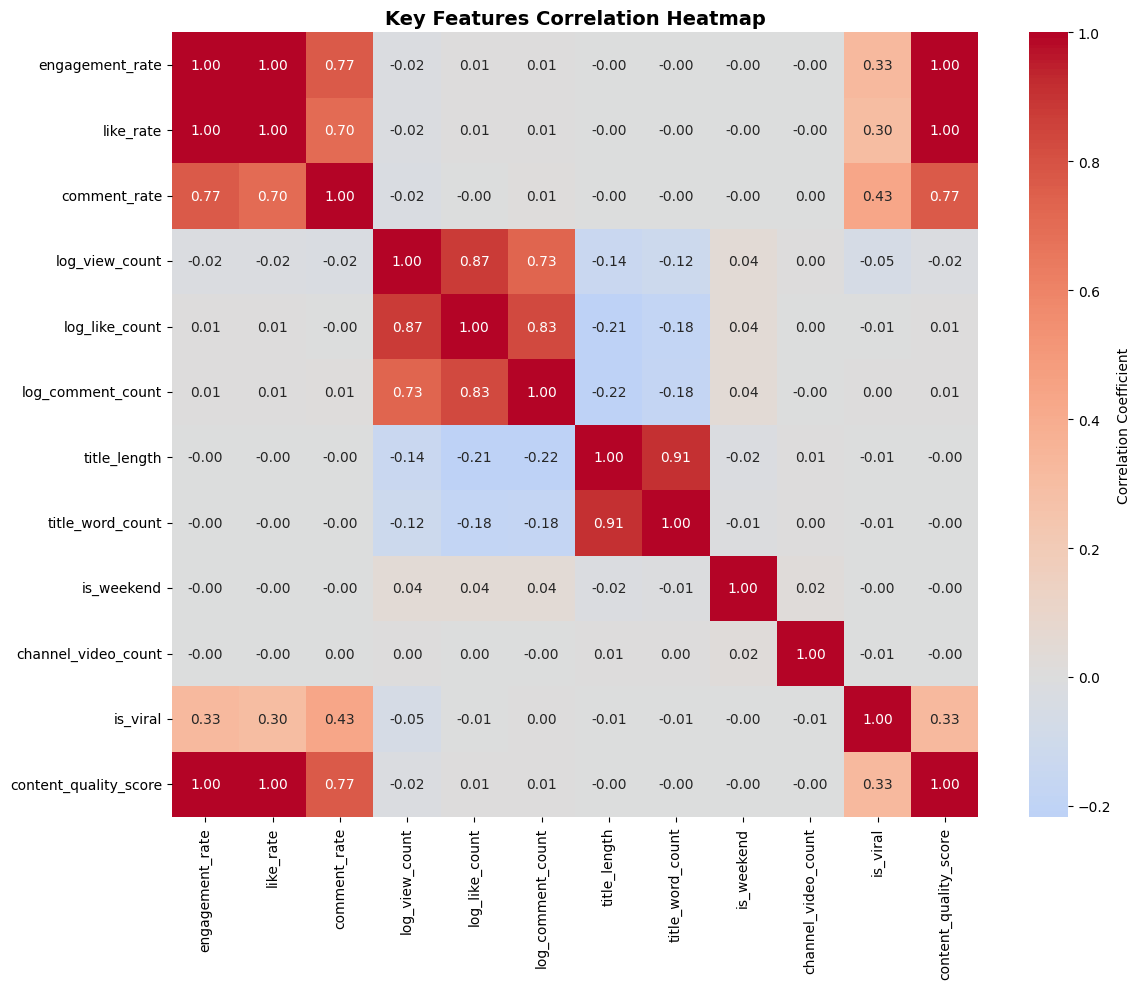

Correlation heatmap generated: feature_correlation_heatmap.png

  Highly correlated feature pairs (correlation > 0.8):
   engagement_rate <-> content_quality_score: 1.000
   like_rate <-> content_quality_score: 0.996
   engagement_rate <-> like_rate: 0.996
   title_length <-> title_word_count: 0.908
   log_view_count <-> log_like_count: 0.872
   log_like_count <-> log_comment_count: 0.832


In [10]:
# Feature correlation analysis
# Select numeric features
numeric_cols = df_features[engineered_cols].select_dtypes(include=[np.number]).columns

# Calculate correlation matrix (select key features for visualization)
key_features = [
    'engagement_rate', 'like_rate', 'comment_rate', 
    'log_view_count', 'log_like_count', 'log_comment_count',
    'title_length', 'title_word_count', 'is_weekend', 
    'channel_video_count', 'is_viral', 'content_quality_score'
]

corr_matrix = df_features[key_features].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Key Features Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('photo/feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation heatmap generated: feature_correlation_heatmap.png")

# Display highly correlated feature pairs
print("\n  Highly correlated feature pairs (correlation > 0.8):")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

corr_pairs = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for feat1, feat2, corr_val in corr_pairs[:10]:
    print(f"   {feat1} <-> {feat2}: {corr_val:.3f}")

## Part 10: Feature Scaling and Save

In [11]:
# Handle infinity and missing values
df_features = df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.fillna(df_features.mean(numeric_only=True))

# Standardize numeric features
numeric_features = df_features[engineered_cols].select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
df_scaled = df_features.copy()
df_scaled[numeric_features] = scaler.fit_transform(df_features[numeric_features])

print("Feature scaling completed")
print(f"   Original data range example: view_count [{df_features['view_count'].min():.2f}, {df_features['view_count'].max():.2f}]")
print(f"   Scaled data range example: view_count [{df_scaled['log_view_count'].min():.2f}, {df_scaled['log_view_count'].max():.2f}]")

# Save raw feature data
output_file_raw = 'engineered_features_raw.csv'
df_features.to_csv(output_file_raw, index=False)
print(f"\n  Saved raw feature data: {output_file_raw}")
print(f"   Size: {len(df_features)} rows × {len(df_features.columns)} columns")

# Save scaled feature data
output_file_scaled = 'engineered_features_scaled.csv'
df_scaled.to_csv(output_file_scaled, index=False)
print(f"  Saved scaled feature data: {output_file_scaled}")

# Save feature metadata
metadata = {
    'total_features': len(engineered_cols),
    'original_columns': original_cols,
    'engineered_columns': engineered_cols,
    'text_features': text_feat,
    'time_features': time_feat,
    'engagement_features': engagement_feat,
    'channel_features': channel_feat,
    'composite_features': composite_feat,
    'total_rows': len(df_features)
}

import json
with open('feature_engineering_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)
print(f"  Saved feature metadata: feature_engineering_metadata.json")

Feature scaling completed
   Original data range example: view_count [0.00, 5367568626.00]
   Scaled data range example: view_count [-3.96, 4.43]

  Saved raw feature data: engineered_features_raw.csv
   Size: 155669 rows × 68 columns

  Saved raw feature data: engineered_features_raw.csv
   Size: 155669 rows × 68 columns
  Saved scaled feature data: engineered_features_scaled.csv
  Saved feature metadata: feature_engineering_metadata.json
  Saved scaled feature data: engineered_features_scaled.csv
  Saved feature metadata: feature_engineering_metadata.json


## Part 11: Feature Importance Analysis

 Top 20 features with highest variance (indicating feature information content):
channel_total_views               8.441566e+15
channel_view_std                  4.725690e+14
channel_avg_views                 1.314740e+14
content_maturity_score            3.520734e+11
total_interactions                2.298895e+10
channel_avg_likes                 8.636608e+09
like_to_comment_ratio             2.111235e+09
title_length_engagement_factor    4.451358e+08
content_quality_score             1.277482e+08
channel_avg_comments              2.651669e+07
days_since_publish                7.519111e+05
engagement_rate                   1.419421e+05
like_rate                         1.162732e+05
weighted_engagement               1.651728e+04
channel_engagement_rate           1.480659e+04
channel_avg_engagement            1.480659e+04
comment_rate                      2.365093e+03
months_since_publish              8.356397e+02
publish_timing_score              7.417250e+02
title_length              

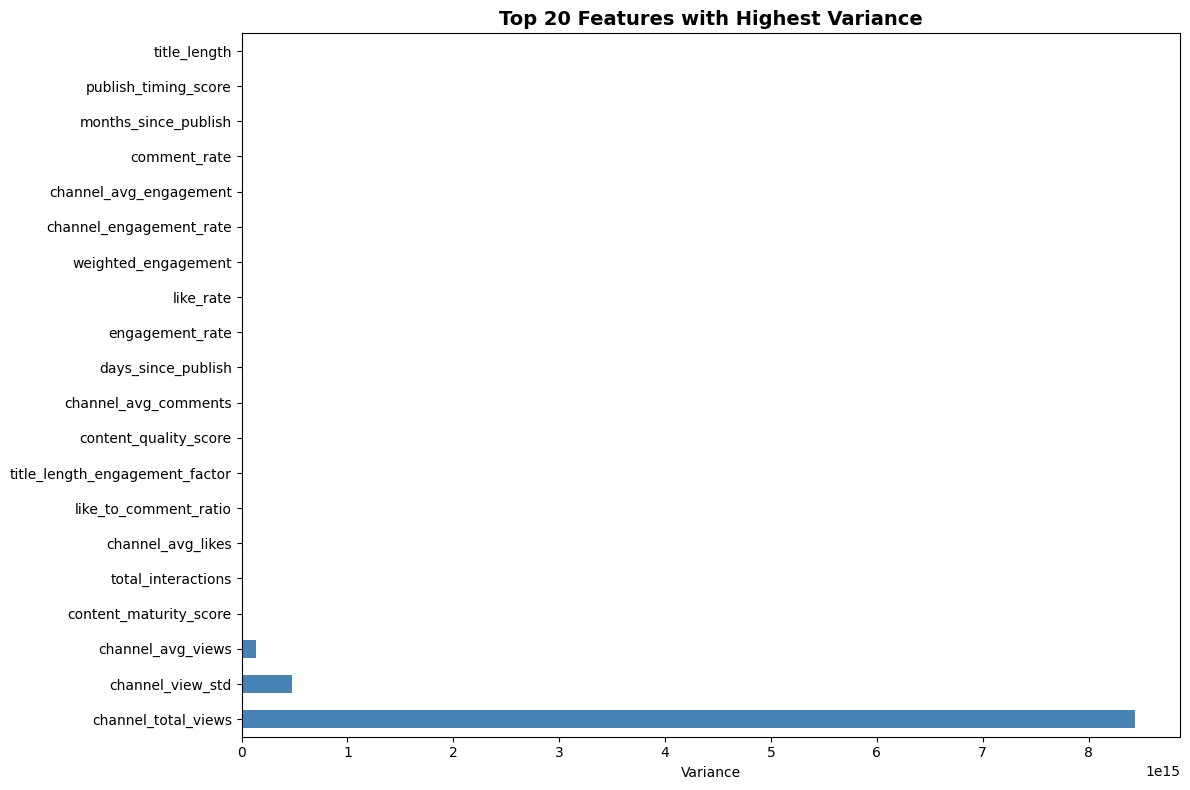


  Feature variance plot generated: feature_variance.png

  Distribution statistics of engineered features:
   Total numeric features: 59
   - Features with mean in 0-100 range: 59
   - Features with max value > 1000: 19
   - Features containing negative values: 1


In [12]:
# Feature importance analysis
# Create target variable (is viral video)
y = df_features['is_viral']

# Calculate feature variance
variances = df_features[numeric_features].var()
variances_sorted = variances.sort_values(ascending=False)

print(" Top 20 features with highest variance (indicating feature information content):")
print(variances_sorted.head(20))

# Plot feature variance
fig, ax = plt.subplots(figsize=(12, 8))
variances_sorted.head(20).plot(kind='barh', ax=ax, color='steelblue')
plt.title('Top 20 Features with Highest Variance', fontsize=14, fontweight='bold')
plt.xlabel('Variance')
plt.tight_layout()
plt.savefig('photo/feature_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n  Feature variance plot generated: feature_variance.png")

# Feature statistical distribution
print("\n  Distribution statistics of engineered features:")
print(f"   Total numeric features: {len(numeric_features)}")
print(f"   - Features with mean in 0-100 range: {(df_features[numeric_features].mean() >= 0).sum()}")
print(f"   - Features with max value > 1000: {(df_features[numeric_features].max() > 1000).sum()}")
print(f"   - Features containing negative values: {(df_features[numeric_features].min() < 0).sum()}")